In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (8, 5)
sns.set(style="whitegrid")

In [15]:
# Блок 1: Чтение данных и первичный осмотр

print('=== БЛОК 1: Чтение файла и начальная проверка ===')

CSV_PATH = 'taxi.csv'

try:
    df = pd.read_csv(CSV_PATH)
except UnicodeDecodeError:
    df = pd.read_csv(CSV_PATH, encoding='cp1251')

print('Размер датасета:', df.shape)
df.head()

# Информация о типах данных
df.info()

# Проверим наличие пропусков
df.isna().sum()


=== БЛОК 1: Чтение файла и начальная проверка ===
Размер датасета: (100000, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  100000 non-null  object 
 1   vendor_id           100000 non-null  int64  
 2   pickup_datetime     100000 non-null  object 
 3   dropoff_datetime    100000 non-null  object 
 4   passenger_count     100000 non-null  int64  
 5   pickup_longitude    100000 non-null  float64
 6   pickup_latitude     100000 non-null  float64
 7   dropoff_longitude   100000 non-null  float64
 8   dropoff_latitude    100000 non-null  float64
 9   store_and_fwd_flag  100000 non-null  object 
 10  trip_duration       100000 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 8.4+ MB


id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [25]:
#  Блок 2: Приведение данных и выбор нужных признаков

print('\n=== БЛОК 2: Приведение и создание DataFrame ===')

cols_lower = df.columns.str.lower()
col_map = dict(zip(df.columns, cols_lower))
df = df.rename(columns=col_map)

print("Доступные колонки в датасете:")
print(df.columns.tolist())

# В вашем датасете есть trip_duration - используем его
duration_col = 'trip_duration'  # принудительно задаем, т.к. она есть в данных

# Выбираем основные колонки которые есть в данных
selected_cols = []
for col in ['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'passenger_count']:
    if col in df.columns:
        selected_cols.append(col)

df = df[selected_cols].copy()
print('Выбранные столбцы:', df.columns.tolist())

# Преобразуем даты
if 'pickup_datetime' in df.columns and 'dropoff_datetime' in df.columns:
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], errors='coerce')
    df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'], errors='coerce')


=== БЛОК 2: Приведение и создание DataFrame ===
Доступные колонки в датасете:
['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'trip_duration']
Выбранные столбцы: ['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'passenger_count']


In [27]:
#  Блок 3: Дополнение DataFrame новыми признаками

print('\n=== БЛОК 3: Новые признаки ===')

# Создаем trip_duration_min из существующего trip_duration (в секундах)
if 'trip_duration' in df.columns:
    df['trip_duration_min'] = df['trip_duration'] / 60
    print("Создан признак trip_duration_min")

# Добавляем временные признаки
if 'pickup_datetime' in df.columns:
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_dow'] = df['pickup_datetime'].dt.day_name()
    print("Созданы временные признаки")

print("\nПервые 5 строк после преобразований:")
print(df.head())



=== БЛОК 3: Новые признаки ===
Создан признак trip_duration_min
Созданы временные признаки

Первые 5 строк после преобразований:
      pickup_datetime    dropoff_datetime  trip_duration  passenger_count  \
0 2016-01-31 13:12:20 2016-01-31 13:21:37            557                2   
1 2016-05-03 18:20:59 2016-05-03 18:41:09           1210                1   
2 2016-06-05 02:20:39 2016-06-05 02:28:04            445                1   
3 2016-01-11 20:07:13 2016-01-11 20:14:26            433                1   
4 2016-01-22 00:31:59 2016-01-22 00:40:48            529                5   

   trip_duration_min  pickup_hour pickup_dow  
0           9.283333           13     Sunday  
1          20.166667           18    Tuesday  
2           7.416667            2     Sunday  
3           7.216667           20     Monday  
4           8.816667            0     Friday  



=== БЛОК 4: Исследование данных ===
Основные статистики:
                      count        mean          std       min    25%    50%  \
trip_duration      100000.0  948.992000  3154.520022  2.000000  396.0  660.0   
passenger_count    100000.0    1.667470     1.318139  0.000000    1.0    1.0   
trip_duration_min  100000.0   15.816533    52.575334  0.033333    6.6   11.0   
pickup_hour        100000.0   13.627240     6.384674  0.000000    9.0   14.0   

                           75%       max  
trip_duration      1072.000000  86379.00  
passenger_count       2.000000      6.00  
trip_duration_min    17.866667   1439.65  
pickup_hour          19.000000     23.00  


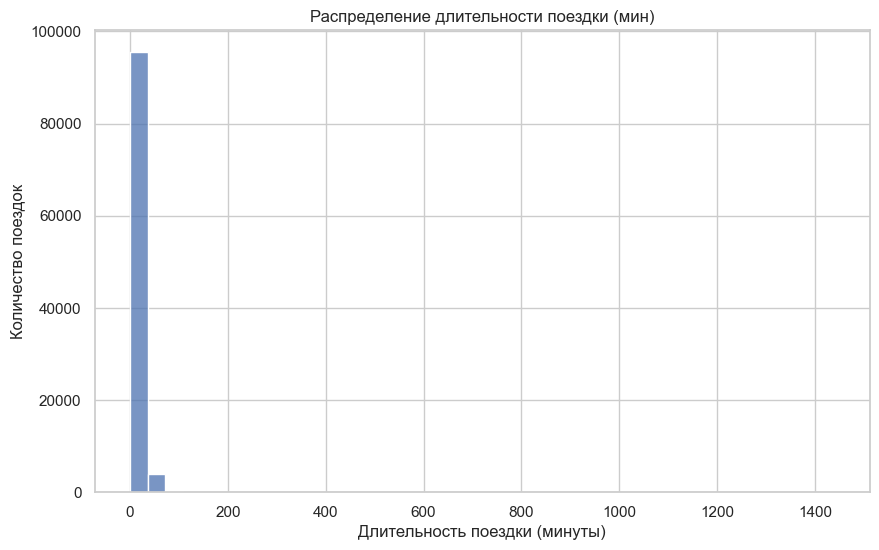

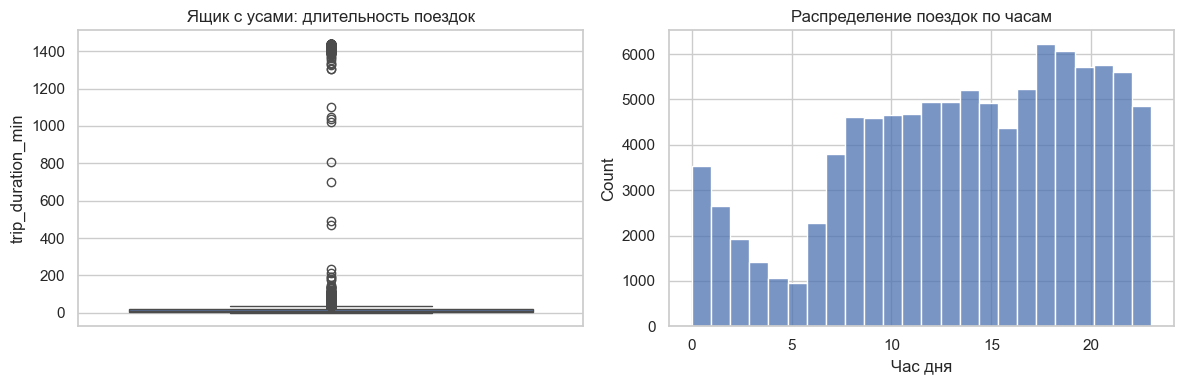

In [29]:
#  Блок 4: Исследовательский анализ данных (EDA)

print('\n=== БЛОК 4: Исследование данных ===')

print("Основные статистики:")
print(df.describe().T)

# Проверяем, создался ли trip_duration_min перед построением графика
if 'trip_duration_min' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(df['trip_duration_min'].dropna(), bins=40, kde=False)
    plt.title('Распределение длительности поездки (мин)')
    plt.xlabel('Длительность поездки (минуты)')
    plt.ylabel('Количество поездок')
    plt.show()
    
    # Дополнительные графики
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(y=df['trip_duration_min'])
    plt.title('Ящик с усами: длительность поездок')
    
    plt.subplot(1, 2, 2)
    sns.histplot(df['pickup_hour'].dropna(), bins=24, kde=False)
    plt.title('Распределение поездок по часам')
    plt.xlabel('Час дня')
    
    plt.tight_layout()
    plt.show()
else:
    print("Признак trip_duration_min не создан, пропускаем построение графиков")


=== БЛОК 5: Кластеризация ===
Доступные признаки для кластеризации: ['trip_duration_min', 'passenger_count', 'pickup_hour']
Размерность данных для кластеризации: (100000, 3)
k=2, silhouette_score=0.936
k=3, silhouette_score=0.536
k=4, silhouette_score=0.498
k=5, silhouette_score=0.439
k=6, silhouette_score=0.435
Выбрано k=2 кластеров (score=0.936)


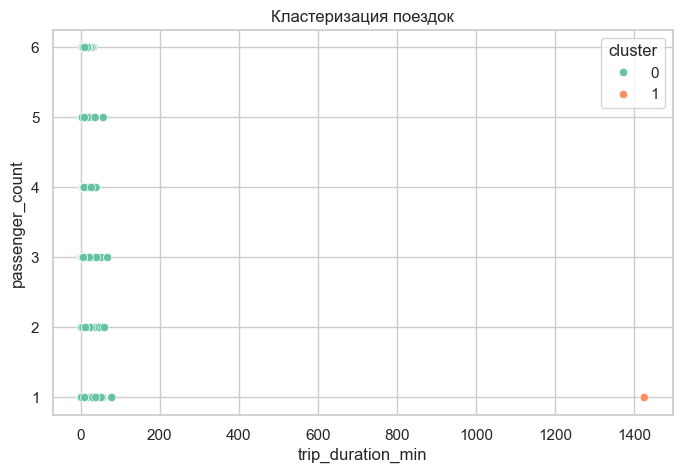


Статистики по кластерам:


,trip_duration_min,passenger_count,pickup_hour
cluster,,,
0,13.93,1.67,13.63
1,1403.84,2.05,13.08


In [31]:
#  Блок 5: Кластеризация поездок

print('\n=== БЛОК 5: Кластеризация ===')

# Используем только те признаки, которые есть в данных
features = []
for f in ['trip_duration_min', 'passenger_count', 'pickup_hour']:
    if f in df.columns:
        features.append(f)

print('Доступные признаки для кластеризации:', features)

if len(features) >= 2:
    X = df[features].copy()
    print(f"Размерность данных для кластеризации: {X.shape}")
    
    # Заполняем пропуски
    imputer = SimpleImputer(strategy='median')
    X_imp = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
    
    # Масштабируем
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imp)
    
    # Выбираем оптимальное число кластеров
    best_k = 2
    best_score = -1
    for k in range(2, min(7, len(X_scaled))):
        try:
            km = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = km.fit_predict(X_scaled)
            score = silhouette_score(X_scaled, labels)
            print(f'k={k}, silhouette_score={score:.3f}')
            if score > best_score:
                best_k, best_score = k, score
        except Exception as e:
            print(f'Ошибка при k={k}: {e}')
            continue
    
    if best_score > -1:
        print(f'Выбрано k={best_k} кластеров (score={best_score:.3f})')
        km = KMeans(n_clusters=best_k, random_state=42, n_init=20)
        df['cluster'] = km.fit_predict(X_scaled)
        
        # Визуализация
        if len(features) >= 2:
            sample_df = df.sample(min(1000, len(df)))
            sns.scatterplot(data=sample_df, x=features[0], y=features[1], hue='cluster', palette='Set2')
            plt.title('Кластеризация поездок')
            plt.show()
        
        # Анализ кластеров
        cluster_stats = df.groupby('cluster')[features].mean().round(2)
        print("\nСтатистики по кластерам:")
        display(cluster_stats)
    else:
        print("Не удалось выполнить кластеризацию")
else:
    print("Недостаточно признаков для кластеризации (нужно минимум 2)")



=== БЛОК 6: A/B анализ ===
Количество поездок в будни: 71589
Количество поездок в выходные: 28411
Средняя длительность (будни): 16.10 мин
Средняя длительность (выходные): 15.11 мин
t-статистика=2.5355, p-value=0.0112
✅ Различия статистически значимы (p < 0.05)


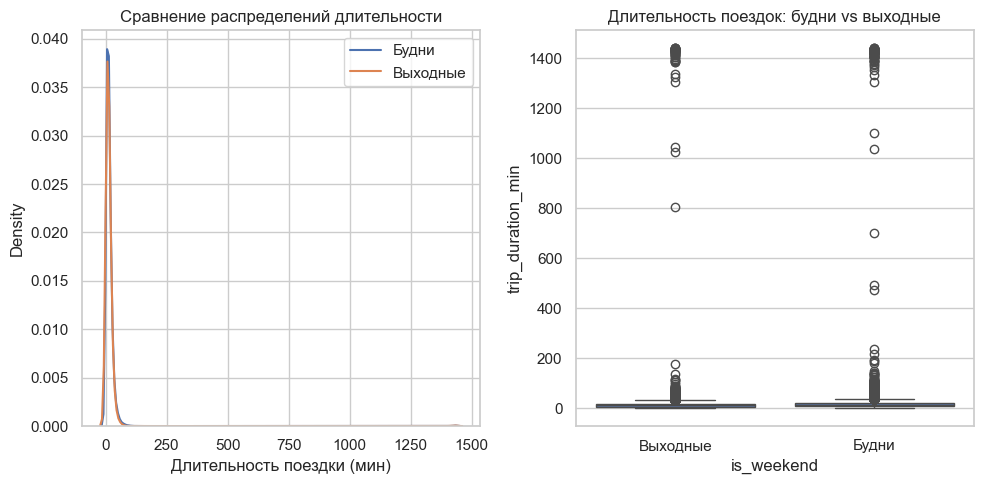

In [32]:
#  Блок 6: A/B анализ (будни vs выходные)

print('\n=== БЛОК 6: A/B анализ ===')

if 'pickup_datetime' in df.columns and 'trip_duration_min' in df.columns:
    df_clean = df.dropna(subset=['pickup_datetime', 'trip_duration_min'])
    df_clean['is_weekend'] = df_clean['pickup_datetime'].dt.dayofweek >= 5
    
    groupA = df_clean[df_clean['is_weekend'] == False]['trip_duration_min']
    groupB = df_clean[df_clean['is_weekend'] == True]['trip_duration_min']
    
    print(f'Количество поездок в будни: {len(groupA)}')
    print(f'Количество поездок в выходные: {len(groupB)}')
    print(f'Средняя длительность (будни): {groupA.mean():.2f} мин')
    print(f'Средняя длительность (выходные): {groupB.mean():.2f} мин')
    
    if len(groupA) > 0 and len(groupB) > 0:
        t_stat, p_val = stats.ttest_ind(groupA, groupB, equal_var=False, nan_policy='omit')
        print(f't-статистика={t_stat:.4f}, p-value={p_val:.4f}')
        
        if p_val < 0.05:
            print('✅ Различия статистически значимы (p < 0.05)')
        else:
            print('❌ Статистически значимых различий не найдено')
        
        # Визуализация
        plt.figure(figsize=(10, 5))
        
        plt.subplot(1, 2, 1)
        sns.kdeplot(groupA, label='Будни')
        sns.kdeplot(groupB, label='Выходные')
        plt.title('Сравнение распределений длительности')
        plt.xlabel('Длительность поездки (мин)')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df_clean['is_weekend'].map({True: 'Выходные', False: 'Будни'}), 
                   y=df_clean['trip_duration_min'])
        plt.title('Длительность поездок: будни vs выходные')
        
        plt.tight_layout()
        plt.show()
    else:
        print("Недостаточно данных для A/B теста")
else:
    print("Отсутствуют необходимые колонки для A/B анализа")